# Exploratory Data Analysis Of Breast Cancer Dataset

### <b>Abstract</b>
#### <b>Introduction</b>
A common frustration in the industry, especially when it comes to getting business insights from tabular data, is that the most interesting questions (from their perspective) are often not answerable with observational data alone. These questions can be similar to:
“What will happen if I halve the price of my product?”
“Which clients will pay their debts only if I call them?”

Judea Pearl and his research group have developed in the last decades a solid theoretical framework to deal with that, but the first steps toward merging it with mainstream machine learning are just beginning. 

The causal graph is a central object in the framework mentioned above, but it is often unknown, subject to personal knowledge and bias, or loosely connected to the available data. The main objective of the task is to highlight the importance of the matter in a concrete way. In this spirit, trainees are expected to attempt the following tasks:
Perform a causal inference task using Pearl’s framework;
Infer the causal graph from observational data and then validate the graph;
Merge machine learning with causal inference;

The first is straightforward, the second and third are still open questions in the research community, hence may need a bit more research, innovation, and thinking outside the box from trainees.


## Import libraries & datasets <a class="anchor" id="importDataset"></a> 


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
data = pd.read_csv("../data/data.csv")

## Data sources and descriptions <a class="anchor" id="dOverview"></a>
### About dataset <a class="anchor" id="aboutDataset"></a>

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:
#### 1. ID number
#### 2. Diagnosis (M = malignant, B = benign) 
#### 3-32 
#### Ten real-valued features are computed for each cell nucleus:
#### a. radius (mean of distances from center to points on the perimeter)
#### b. texture (standard deviation of gray-scale values)
#### c. perimeter 
#### d) area 
#### e) smoothness (local variation in radius lengths)
#### f. compactness (perimeter^2 / area - 1.0)
#### g. concavity (severity of concave portions of the contour)
#### h. concave points (number of concave portions of the contour)
#### i. symmetry 
#### j) fractal dimension ("coastline approximation" - 1)
The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.
Missing attribute values: none
Class distribution: 357 benign, 212 malignant
### check-up of the dataset <a class="anchor" id="charDataset"></a>

#### Check dimension of the dataset, missing values and data type.

In [7]:
def data_checks(df: pd.DataFrame):
        """
        perform checks in the dataset

        args: 
            df (pd.DataFrame): the DataFrame which we are performing checks
        
        returns:
            dictionary of checks

        """
        checks = {
            "info":df.info(),
            "shape":df.shape,
            "uniqueness":df.apply(lambda x: len(x.unique())).sort_values(ascending=False).head(10),
            "missing_values":df.isnull().sum(),
            "duplicates":df.duplicated().sum(),
            "data_snapshot":df.head()

        }
        return checks

In [8]:
data_checks(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

{'info': None,
 'shape': (569, 33),
 'uniqueness': id                      569
 smoothness_se           547
 fractal_dimension_se    545
 area_worst              544
 concave points_mean     542
 compactness_se          541
 radius_se               540
 area_mean               539
 concavity_worst         539
 compactness_mean        537
 dtype: int64,
 'missing_values': id                           0
 diagnosis                    0
 radius_mean                  0
 texture_mean                 0
 perimeter_mean               0
 area_mean                    0
 smoothness_mean              0
 compactness_mean             0
 concavity_mean               0
 concave points_mean          0
 symmetry_mean                0
 fractal_dimension_mean       0
 radius_se                    0
 texture_se                   0
 perimeter_se                 0
 area_se                      0
 smoothness_se                0
 compactness_se               0
 concavity_se                 0
 concave points_se 

After performing a health check on our dataset we can notice that only the <b>ID column</b> is unique. We also notice that the last column 'unnamed 32' is not really necessary, because it is an empty column, and then the next thing we notice with our data, is that there are no missing values, and that all the variables apart from diagnosis and id are float types, The id value we may not use it for our analysis, the diagnosis column shall act as our y, our dependent variable, this is the variable that we shall be modelling and making predictions about.
##  In summary <a class="anchor" id = "summaryData"></a>

We can conclude that:
<ul>
    <li>There are <b>569</b> instances of <b>data</b>.</li>
    <li>Total number of <b>features</b> equals <b>33</b>, of which <b>31 is numerical, </b> plus <b>Id</b> and <b>diagnosis.</b></li>
    <li>One <b>feature (Unnamed: 32)</b> has missing values in the dataset</li>
    <li> There is one unique column which is <b>'Id'</b></li>
    <li> No <b>duplicate</b> records</li>
 </ul>

#### Missing value analysis

In [14]:
def missing_value_analysis(data:pd.DataFrame):
    """
    this function is for performing analysis on missing values
    
    args:
        data (pd.DataFrame): input the dataframe to perform analysis upon
    
    return:
        returns a plot of all the missing value columns and their frequenct
    """
    cols_with_missing = data.isnull().sum()
    cols_with_missing = cols_with_missing[cols_with_missing>0]
    cols_with_missing.sort_values(inplace=True)
    fig, ax = plt.subplots(figsize=(7,6))  
    width = 0.70 # the width of the bars 
    ind = np.arange(len(cols_with_missing))  # the x locations for the groups
    ax.barh(ind, cols_with_missing, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(cols_with_missing.index, minor=False)
    plt.xlabel('Count')
    plt.ylabel('Features') 

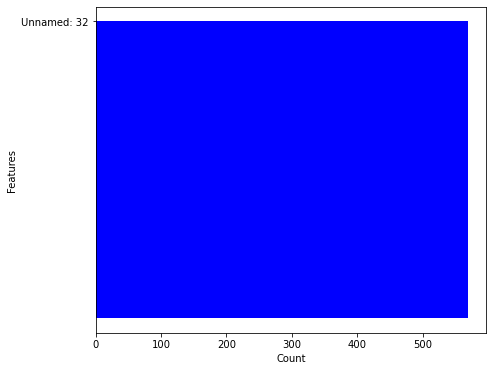

In [13]:
missing_value_analysis(data)

We notice that <b>Unnamed 32</b> has the missing values only. And this one we cannot perform any filling techniques, because this column simply has no data

#### Drop unnecessary <b>column</b> from dataset

In [9]:
# Get column names
col = data.columns
print(col)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


We can therefore exclude unnecessary columns from the dataset and separate dependent (y) and and independent(X) data:
* <b>There is an id that cannot be used for classification.</b>
*  <b>Diagnosis is our class label.</b>
*  <b>Unnamed: 32 feature includes NaN so we do not need it.</b>

In [22]:
def get_xy(data:pd.DataFrame,list_drp:list):
    """
    set the x and y column
    
    args:
        data(pd.DataFrame): the dataFrame which we are extracting the x and y
    
    returns:
        y and X in form of pandas series
    
    """
    y = data.diagnosis # M or B 
    X = data.drop(list_drp,axis = 1 )
    return y,X

In [23]:
y,X = get_xy(data,['Unnamed: 32','id','diagnosis'])

##  Descriptive Statistics <a class="anchor" id = "sOverview"></a>


### Description of the dataset<a class="anchor" id="desDataset"></a>


Statistical information can be viewed in the below table. For numerical parameters, fields like mean, standard deviation, percentiles, and maximum have been populated. This gives us a broad idea of our dataset. We shall begin by describing our <b>X</b> variable, that is our independent variable

In [30]:
def describe_independent(X):
    """
    gets data subset to describe and performs simple descriptive measures
    on the independent variable
    
    args:
        X (pd.DataFrame): a subset of the main data
    
    returns:
        description in form of a dataframe
    """
    return X.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

In [25]:
describe_independent(X)

### Analysis of the dependent variable (diagnosis)<a class="anchor" id="distOutcome"></a>

We shall then analyse our dependent variable

In [28]:
def describe_dependent(y):
    """
    gets the independent variable and performs simple descriptive measures, like counts
    
    args: 
        y (pd.DataFrame): y column of dependent variable
    
    returns:
        plot of counts of the dependent variable
    """
    ax = sns.countplot(y,label="Count")       # M = 212, B = 357
    B, M = y.value_counts()
    print('Number of Benign: ',B)
    print('Number of Malignant : ',M)
    ax.set_ylabel('Number of patients')
    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]
    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r
        ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
        ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

Number of Benign:  357
Number of Malignant :  212


/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


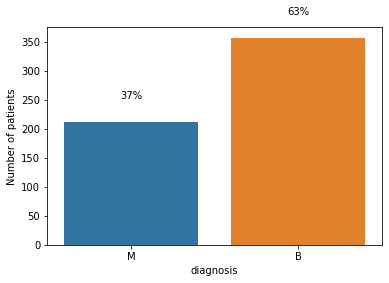

In [29]:
describe_dependent(y)

##  In summary <a class="anchor" id = "5noSummaryData"></a>

We can conclude that:
* Important summary statistics of all the numerical variables like the mean, std, min, 25%, 50%, 75%, and max values.
* There is <b>high variation</b> in values in <b>area_mean</b>,<b>area_worst,</b>,<b>perimeter_worst</b>,<b>perimeter_mean</b> and <b>area_se</b>
* There are many variables have median value 0.
* The <b>area_worst</b> feature’s max value is <b>4254</b> and <b>fractal_dimension_se</b> features’ max <b>0.029840</b>. This indicates we need to standardize or normalize data before visualization, feature selection, and classification.
* <b>Bar plot</b> of <b>diagnosis</b> shows that <b>Malignant</b> and <b>Benign</b> patients ratio is <b>37% (212/569)</b> and <b>63% (357/569)</b> respectively. 

## Distributions<a class="anchor" id="distributions"></a>

### Distribution of all numerical independent features<a class="anchor" id="distIndependent"></a>

We applied <b>Shapiro–Wilk test</b> to all the numerical features to check whether they follow a normal distribution or not.Which is on the independent features

In [34]:
def test_data_normality(x):
    """
    a function to perform tests on normality
    
    args:
        x (pd.DataFrame):independent variable
    
    returns:
        boolean True or False
    """
    
    test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
    normal = pd.DataFrame(X)
    normal = normal.apply(test_normality)
    return (not normal.any())

In [33]:
test_data_normality(X)

False

And the result is <b>False</b> means none of the numerical features follow the normal distribution.

####  Exploring data using violinplot<a class="anchor" id="violinplot"></a>

A violinplot is a graphical representation of data where values are depicted by color. A violin plot pursues the same activity that a whisker or box plot does.

Before plotting our data we need to normalization or standardization. Because differences between values of features are very high to observe on plot. We plot features in two groups and each group includes 15 features to observe better.

<b>Violin plot for first 15 features (1-15).</b>

In [37]:
def visualize_variability(X:pd.DataFrame,y:pd.DataFrame,start:int,stop:int):
    """
    displays variability through violin plot
    
    args:
        X (pd.DataFrame): independent variables
        y (pd.DataFrame): dependent variables
        start (int): where to start in terms of features 
        stop (int): where to stop in terms of features
    
    returns:
        violin plots
    """
    data_dia = y
    data = X
    # standardization of the data
    data_n_2 = (data - data.mean()) / (data.std())
    data = pd.concat([y,data_n_2.iloc[:,start:stop]],axis=1)
    data = pd.melt(data,id_vars="diagnosis",
                        var_name="features",
                        value_name='value')
    plt.figure(figsize=(10,10))
    sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart",palette ="Set2")
    plt.xticks(rotation=90)

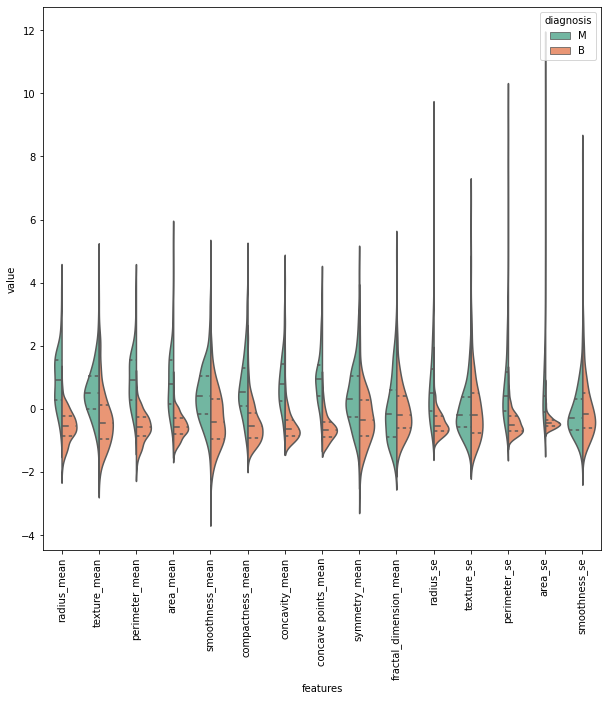

In [38]:
visualize_variability(X,y,0,15)

Lets interpret the plot above together. Green represents Malignant cases and orange Benign. For example, in <b>radius_mean,texture_mean,perimeter_mean, area_mean, compactness_mean, concavity_mean and concave_points_mean</b> features, median of the Malignant and Benign looks like separated so it can be good for classification. However, in <b>fractal_dimension_mean, texture_se, and smoothness_se features</b>, median of the Malignant and Benign does not looks like separated so it does not gives good information for classification.

<b>Violin plot for next 15 features (15-30).</b>

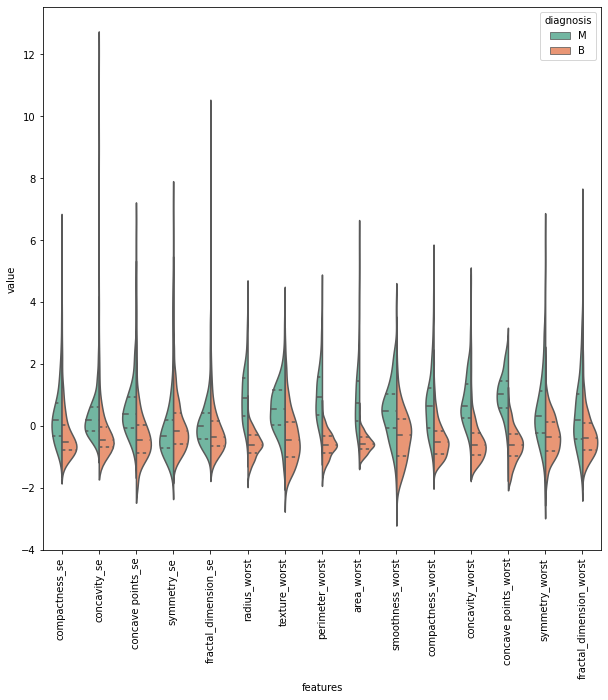

In [39]:
visualize_variability(X,y,15,30)

Lets interpret one more thing about plots above, variable of <b>texture_se, smoothness_se, concavity_worst, and concave point_worst looks like similar</b> but how can we decide whether they are correlated with each other or not. (Not always true but, basically if the features are correlated with each other we can drop one of them)


#### Exploring data using swarmplot<a class="anchor" id="swarmplot"></a>

A swarm plot is very similar to a strip plot. It is basically a scatter plot where the x axis represents a categorical variable. Typical uses of a strip plot involves applying a small random jitter value to each data point such that the separation between points becomes clearer:

Before plotting our data we need to normalization or standardization. Because differences between values of features are very high to observe on plot. I plot features in two groups and each group includes 15 features to observe better.

In [45]:
def visualize_spread(X:pd.DataFrame,y:pd.DataFrame,start:int,stop:int):
    """
    displays spread through swarm plot
    
    args:
        X (pd.DataFrame): independent variables
        y (pd.DataFrame): dependent variables
        start (int): where to start in terms of features 
        stop (int): where to stop in terms of features
    
    returns:
        swarm plots
    """
    # First 15 features
    sns.set(style="whitegrid", palette="Set1")
    data_dia = y
    data = X
    data_n_2 = (data - data.mean()) / (data.std())              # standardization
    data = pd.concat([y,data_n_2.iloc[:,start:stop]],axis=1)
    data = pd.melt(data,id_vars="diagnosis",
                        var_name="features",
                        value_name='value')
    plt.figure(figsize=(10,10))
    #tic = time.time()
    sns.swarmplot(x="features", y="value", hue="diagnosis", data=data)
    plt.xticks(rotation=90)

<b>Swarm plot for first 15 features (1-15).</b>

/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 69.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 70.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 70.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 73.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/hom

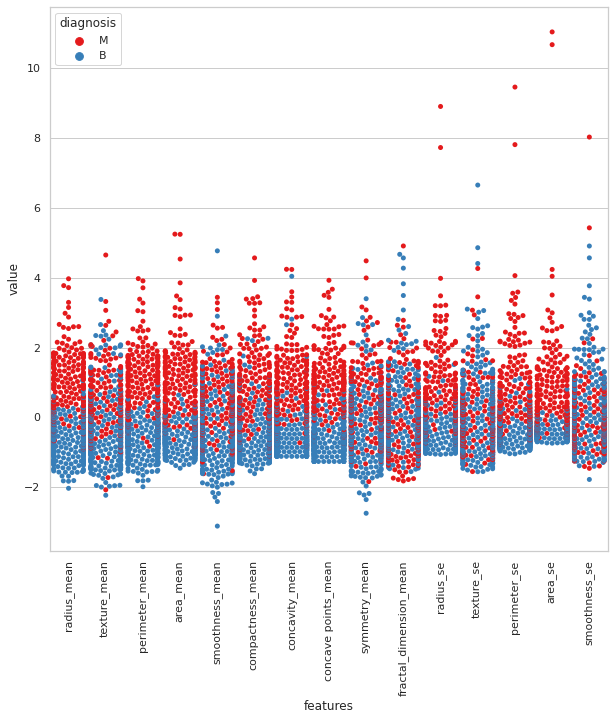

In [43]:
visualize_spread(X,y,0,15)

Each dot represents a cancer patients. Red indicates Malignant and blue Benign pateints. They looks cool right and we can see variance more clear. Let me ask you a question, in these two plots which feature looks like more clear in terms of classification. In my opinion <b>radius_mean, area_se</b> in the above swarm plot looks like malignant and benign are separated not totally but mostly. However, <b>smoothness_mean,symmetry_mean, fractal_dimension_mean, and texture_mean</b> in the above swarm plot looks like malignant and benign are mixed so it is hard to classify while using these feature.

<b>Swarm plot for next 15 features (15-30).</b>

/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 74.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 78.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 72.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/hom

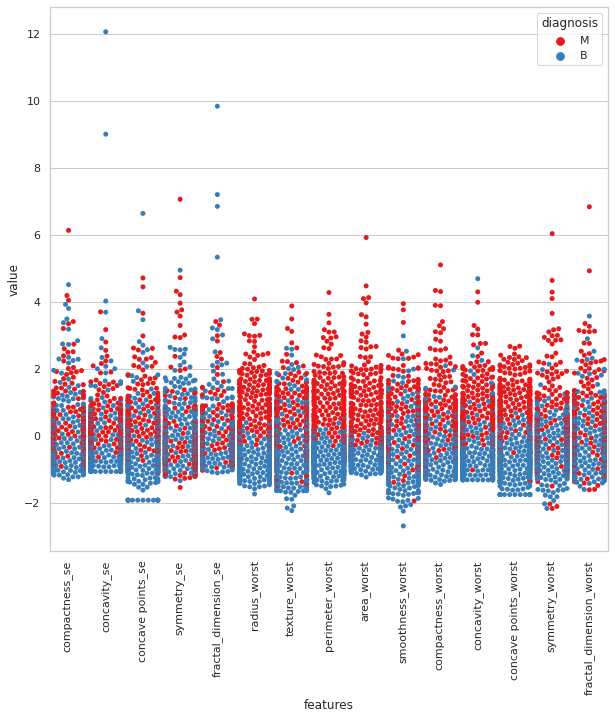

In [44]:
visualize_spread(X,y,15,30)

Smilarly, in my opinion <b>radius_worst, area_worst</b> in the above swarm plot looks like malignant and benign are separated not totally but mostly. However, <b>compactness_se,symmetry_se, and smoothness_worst</b> in the above swarm plot looks like malignant and benign are mixed so it is hard to classify while using these feature.

##  In summary <a class="anchor" id = "summaryDistribution"></a>

We can conclude that:
* <b>None</b> of the continuous feature follows normal distribution. 
* vialinplot and swarmplot can be used to see the distribution of cases.
* We can interprete from violin plot, features <b>radius_mean,texture_mean,perimeter_mean, area_mean, compactness_mean, concavity_mean, and concave_points_mean</b> may be good for cancer classification.
* Pair of variables of <b>(concavity_worst, and concave point_worst), (concavity_mean and concave point_mean), and (concavity_se and concave point_se)</b> looks like similar. Check correlation between them. 
* Swarm plot indicates variables <b>radius_mean, area_se, radius_worst, and area_worst</b> looks like malignant and benign are separated not totally but mostly.

## Bivariate Analysis<a class="anchor" id="relationship"></a>
#### Exploring data using joint plot<a class="anchor" id="jointPlot"></a>

Check both the distribution and relationship between two variables. From above information from violin and swarm plot, lets check the correlation between similar variables. 



In [53]:
def plot_correlation(X:pd.DataFrame,column_1:str,column_2:str,col:str):
    """
    plot correlations between two columns
    
    args:
        X (pd.DataFrame): dataframe of independent variable
        column_1 (string): gets first column
        column_2 (string): gets second column
        col (str): type of color plot should come out as
    
    returns:
        joint plot of the two variables
    """

    sns.set(style="white",color_codes=True)
    jp=sns.jointplot(X.loc[:,column_1], X.loc[:,column_2], kind="reg",color=col)

    #jp.annotate(stats.pearsonr(X.loc[:,'concavity_worst'], X.loc[:,'concave points_worst']))
    r, p = stats.pearsonr(X.loc[:,'concavity_worst'], X.loc[:,'concave points_worst'])
    jp.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                        xy=(0.1, 0.9), xycoords='axes fraction',
                        ha='left', va='center',
                        bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

<b>Check correlation between concavity_worst and concave point_worst using joint plot.</b>


/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


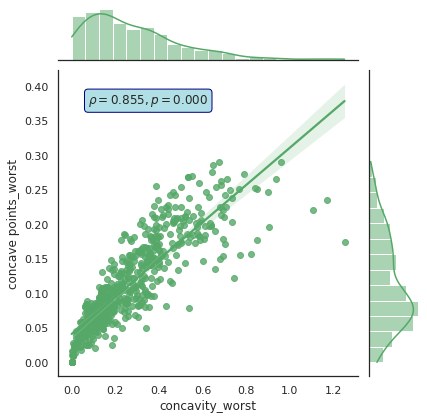

In [50]:
plot_correlation(X,'concavity_worst','concave points_worst','g')

<b>Check correlation between concavity_mean and concave point_mean using joint plot.</b>

/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


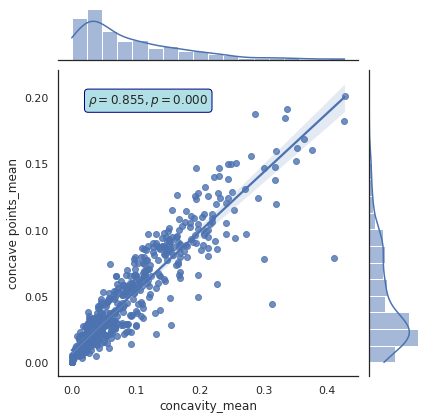

In [51]:
plot_correlation(X,'concavity_mean','concave points_mean','b')

<b>Check correlation between concavity_se and concave point_se using joint plot.</b>

/home/martin/miniconda3/envs/causality/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


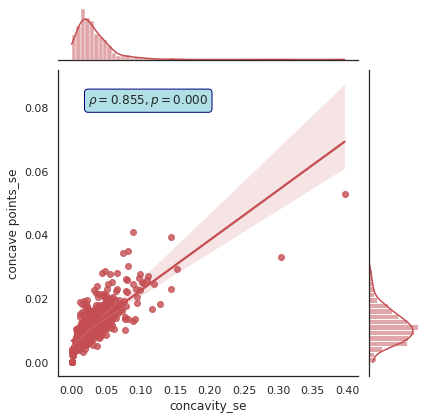

In [52]:
plot_correlation(X,'concavity_se','concave points_se','r')

#### Explore pairplots between dependent and independent features<a class="anchor" id="pairplots"></a>

Pair plots to check both the distribution of single variable and relationship between two variables.



In [54]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 11, xycoords = ax.transAxes)


In [56]:
# First six features
def pair_plot_features(y:pd.DataFrame,X:pd.DataFrame,start:int,stop:int):
    """
    perform pair plot on set of variables
    
    args:
        y (pd.DataFrame): dataframe of dependent variable
        X (pd.DataFrame): dataframe of independent variable
        start (int): where to start in independent variables
        stop (int): where to stop in independent variables
    
    returns:
        pair plots of set of features from start to stop
    """
    data = X
    data_n_2 = (data - data.mean()) / (data.std())              # standardization
    data = pd.concat([y,data_n_2.iloc[:,start:stop]],axis=1)
    plt.figure(figsize=(10,10))
    grid=sns.pairplot(data=data,kind ="scatter",hue="diagnosis",palette="Set1")
    grid = grid.map_upper(corr)

<b>Pairplot for first six features (1-6).</b>

<Figure size 720x720 with 0 Axes>

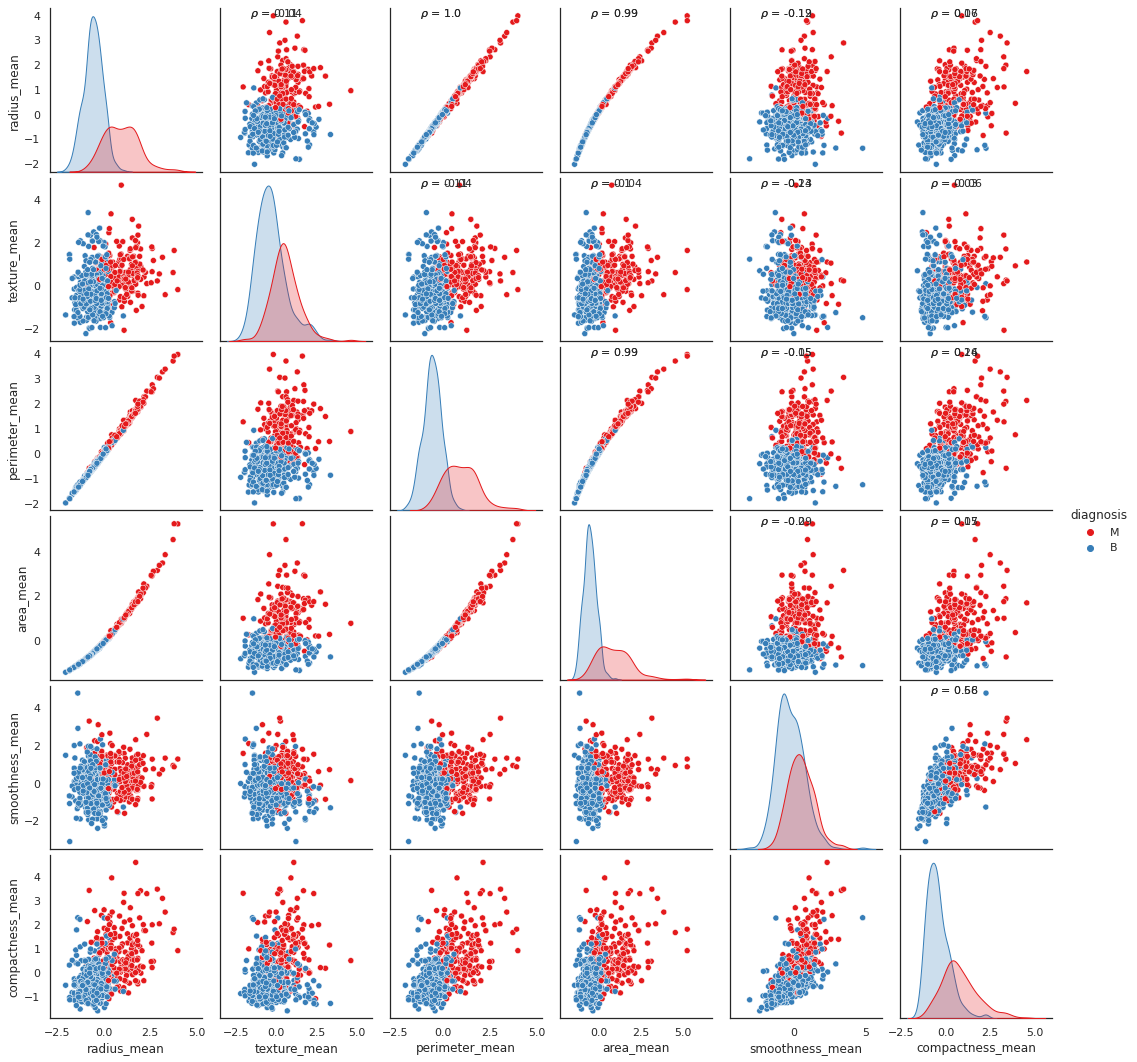

In [57]:
pair_plot_features(y,X,0,6)

<b>Pairplot for next six features (7-12).</b>

<Figure size 720x720 with 0 Axes>

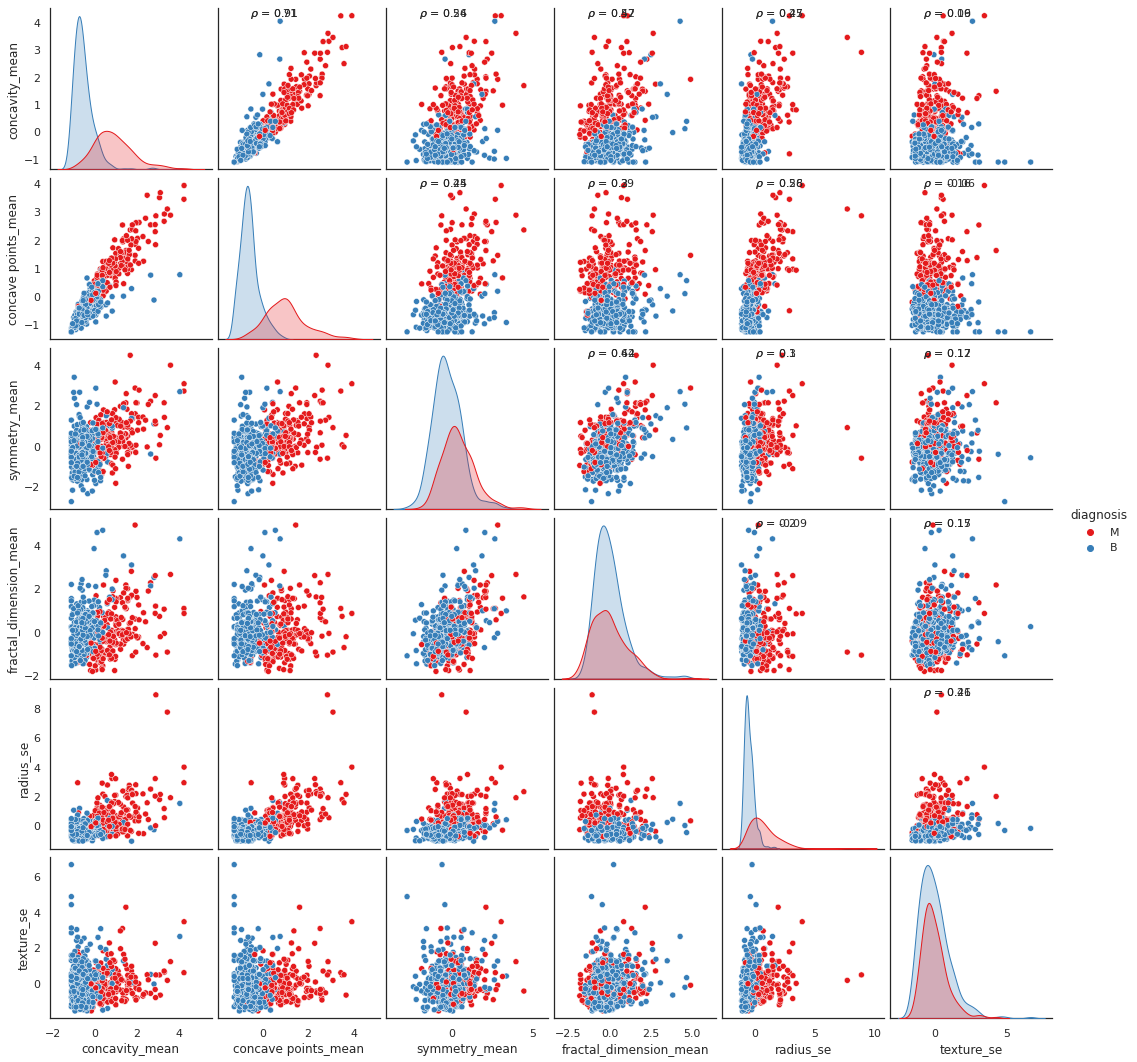

In [58]:
pair_plot_features(y,X,6,12)


<b>Pairplot for next six features (12-18).</b>

<Figure size 720x720 with 0 Axes>

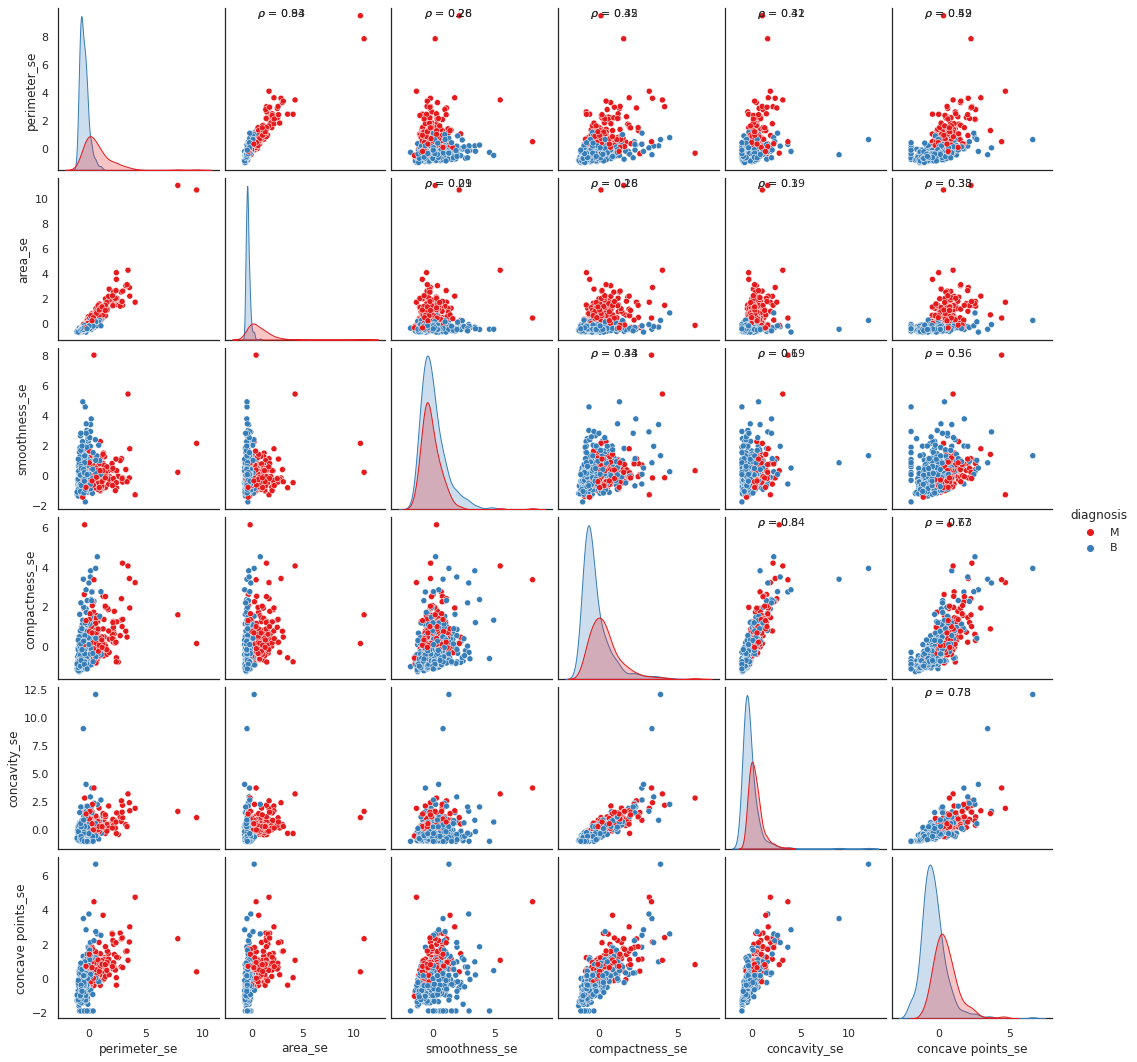

In [59]:
pair_plot_features(y,X,12,18)

<b>Pairplot for next six features (18-24).</b>

<Figure size 720x720 with 0 Axes>

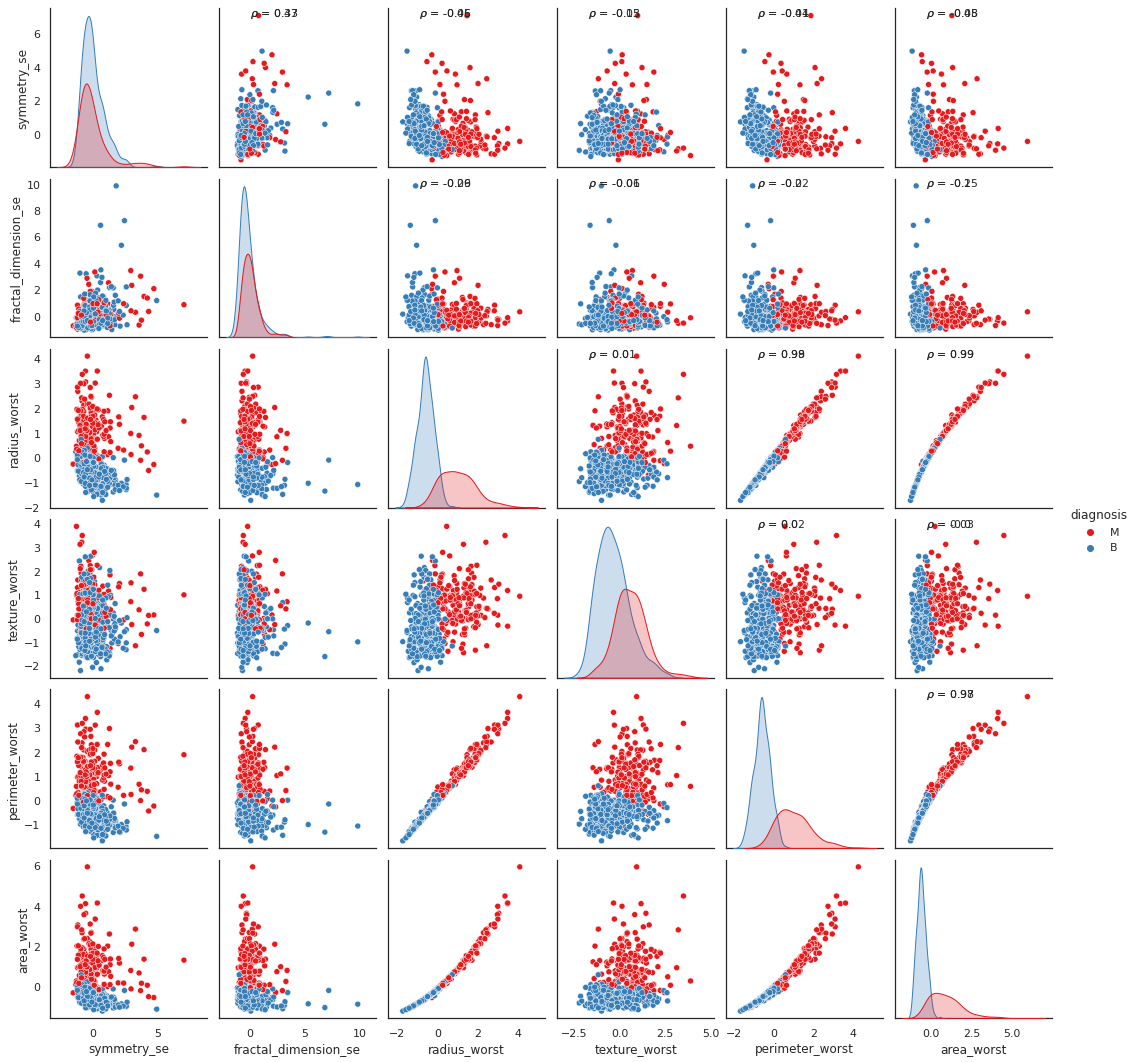

In [60]:
pair_plot_features(y,X,18,24)

<b>Pairplot for next six features (24-30).</b>

<Figure size 720x720 with 0 Axes>

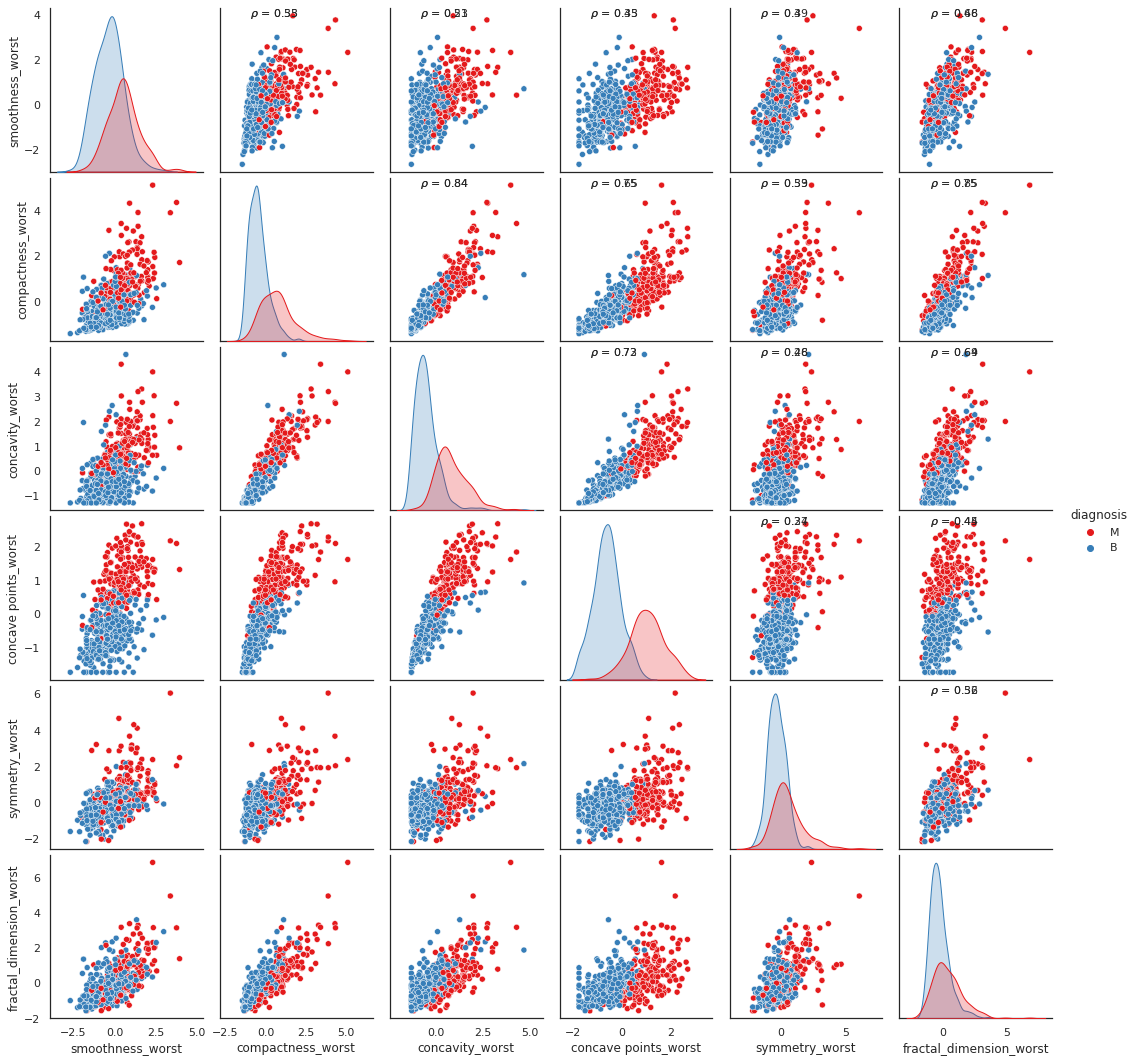

In [61]:
pair_plot_features(y,X,24,30)

#### Check heatmap of independent variables<a class="anchor" id="heatmap"></a>

A heatmap (or heat map) is a graphical representation of data where values are depicted by color. Here we will generate the heatmap of correlation matrix of continuous features. 

In [64]:
#correlation matrix
def plot_correlation_heatmap(X:pd.DataFrame):
    """
    plot correlations of the different variables
    
    args:
        X (pd.DataFrame): a dataframe of the independent variables
    
    returns:
        a heatmap of the correlation
    """
    corrmat = X.corr()
    f, ax = plt.subplots(figsize=(20, 9))
    sns.heatmap(corrmat, annot=True, linewidths=.5, fmt= '.1f',ax=ax);

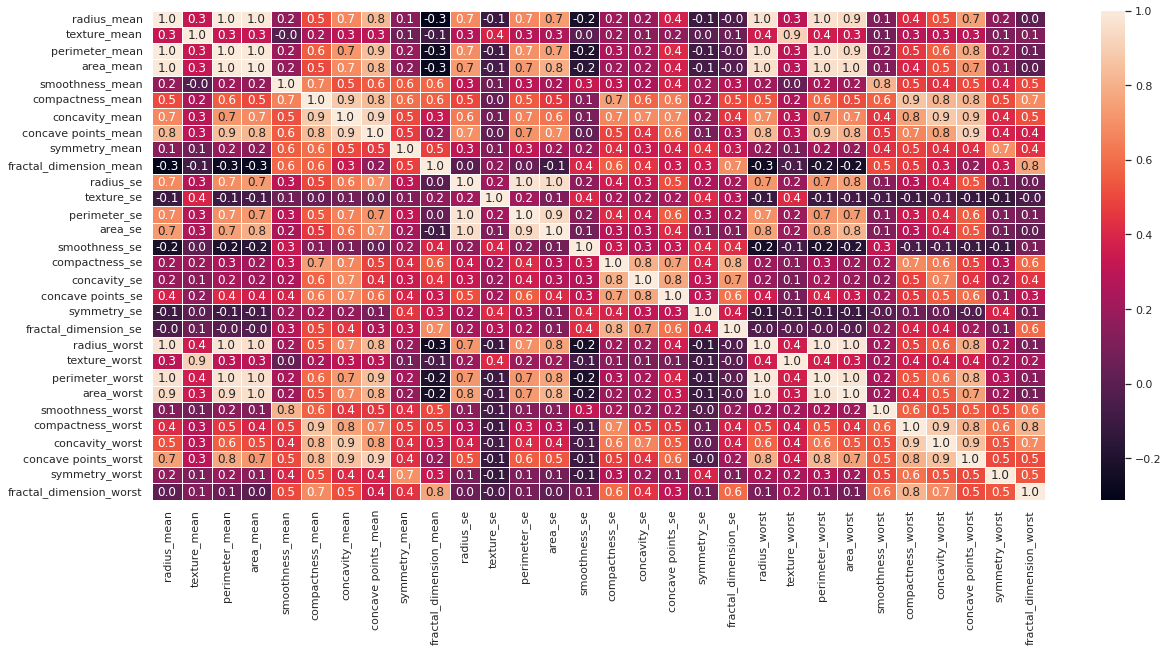

In [63]:
plot_correlation_heatmap(X)

As it can be seen in heat map plot <b>radius_mean, perimeter_mean and area_mean</b> are highly correlated with each other so we can use one of them. If you ask how we choose one as a feature to use, well actually there is no correct answer. 

Compactness_mean, concavity_mean and concave points_mean are correlated with each other. Therefore we can choose one of them. Apart from these, radius_se, perimeter_se and area_se are correlated and we can use one of them. radius_worst, perimeter_worst and area_worst are correlated so we can use one of them. Compactness_worst, concavity_worst and concave points_worst so we can use one of them. Compactness_se, concavity_se and concave points_se so we can use one them. texture_mean and texture_worst are correlated and we can use one of them. area_worst and area_mean are correlated, we can use one of them.

<b>Lets drop correlated variables and check again heat map.</b>

In [66]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave points_worst','compactness_se','concave points_se','texture_worst','area_worst']
x_1 = X.drop(drop_list1,axis = 1 ) 

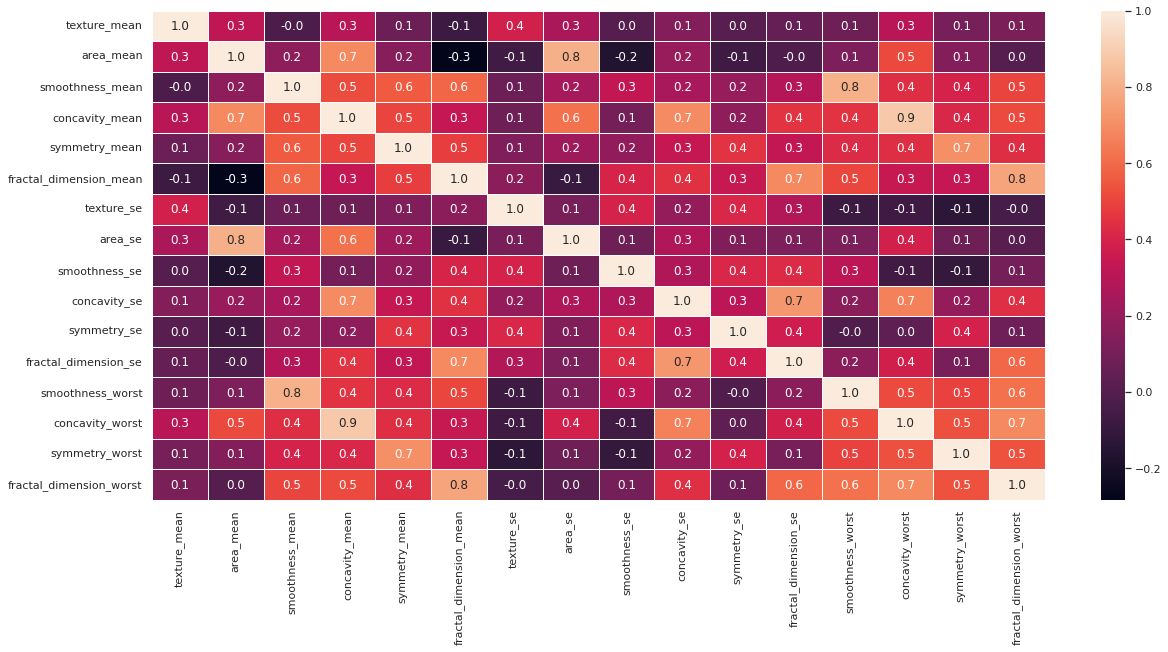

In [67]:
plot_correlation_heatmap(x_1)

After drop correlated features, as it can be seen in above correlation matrix, there is only one high correlation value 0.9 between concavity_mean and concavity_worst.